# Aperture
The purpose of this notebook is to show all sub-functions necessary to compute the aperture distribution in a single dish radio telescope (or emitting antenna). The aperture, $E(x, y)$ is a 2-dim function which depends on,
$$ E(x, y) = E_\mathrm{a}(x, y) \cdot S(x, y) \cdot \mathrm{e}^{-\mathrm{i}\phi(x, y)}  $$
Where is $E_\text{a}(x, y)$ is the illumination function, or taper. The $S(x, y)$ is the telescope's geometry or blockage and $\phi(x, y)$ the phase or wavefront distribution.


In [1]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [39]:
# importing math and plot packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import ascii  # to read examples
from pyoof import telgeometry, aperture, cart2pol
plt.style.use('../pyoof/pyoof.mplstyle')  # it is in the pyoof directory

# Golden ratio
factor = 7
phi = 1.61803398875 * factor
matplotlib.rcParams['figure.figsize'] = (phi, factor)
matplotlib.rcParams['figure.subplot.wspace'] = 

### Blockage
The blockage or the telecope geometry is specific for every telescope. In general the structure it is given by a main dish and a sub-reflector dish. From the OOF study, it has been found that the structure plays an important role in the least squares beam fit procedure and it is suggested to make it as accurate as possible.
Below is the case for a generic telescope configuration and Effelsberg.

In [40]:
pr = 50  # Efffelsber primary reflector radius in meters
box_size = pr
x = np.linspace(-box_size, box_size, 1e3)  # squared mesh
x_grid, y_grid = np.meshgrid(x, x)

# Let's look up at some of the basic parameters of a manual configuration
print(help(telgeometry.blockage_manual))

Help on function blockage_manual in module pyoof.telgeometry.telgeometry:

blockage_manual(pr, sr, a, L)
    Truncation for the aperture function, manual set up for the primary radius
    (pr), secondary radius (sr), hald thickness of a support leg (a) and
    length of the support leg (L) measured from the edge of the sr. It has been
    considered 4 support legs. To omit sr, a and L set them to zero.
    
    Parameters
    ----------
    pr : float
        Primary reflector radius.
    sr : float
        Seconday reflector radius.
    a : float
        Half thickness of a support leg.
    L : float
        Length of a support leg, measured from the edge of the sr to its end.
    
    Returns
    -------
    block : func
        It returns the function block(x, y), which depends only on the grid
        values.

None


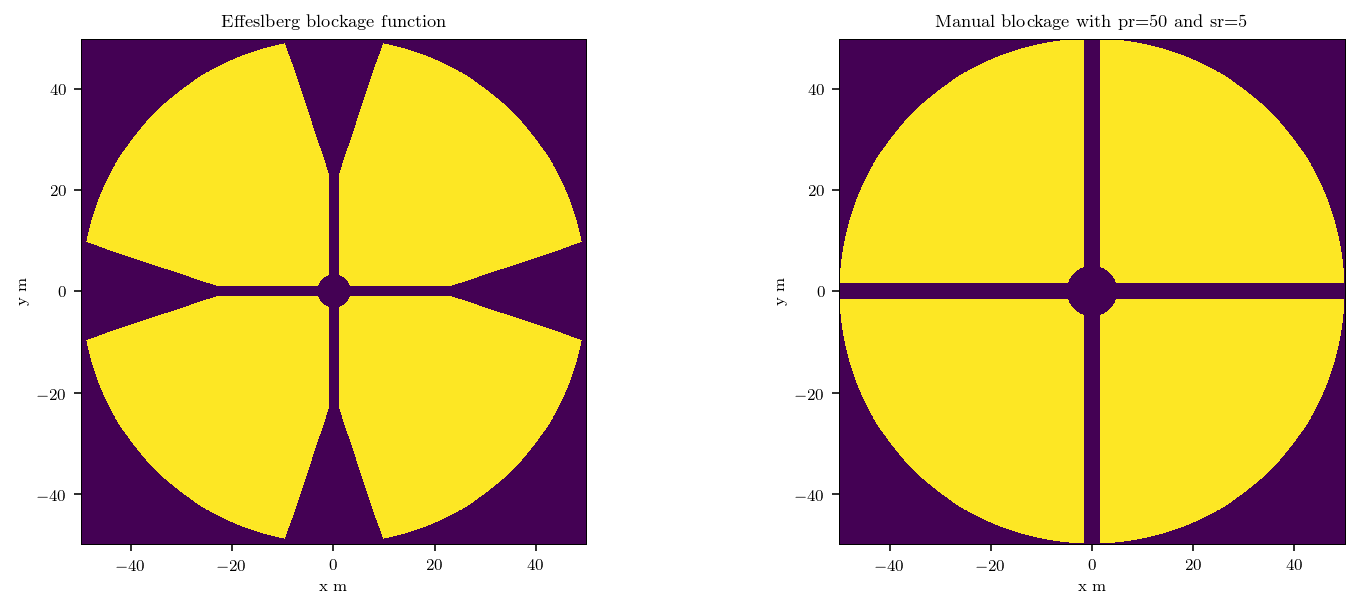

In [42]:
# Testing the blockage functions
sr = 5  # sub-reflector radius in meters
a = 1.5  # halfthicknes of the support legs
L = pr - sr  # length legs, pr - sr from edge to sr 

_blockage_manual = telgeometry.blockage_manual(pr=pr, sr=5, a=1.5, L=50)(x=x_grid, y=y_grid)
_blockage_effelsberg = telgeometry.blockage_effelsberg(x=x_grid, y=y_grid)

fig, ax = plt.subplots(ncols=2)

extent = [-box_size, box_size, -box_size, box_size]
    
ax[0].set_title('Effeslberg blockage function')
ax[0].imshow(_blockage_effelsberg, extent=extent, origin='lower')

ax[1].set_title('Manual blockage with pr=' + str(pr) + ' and sr=' + str(sr))
ax[1].imshow(_blockage_manual, extent=extent, origin='lower')

for _ax in ax:
    _ax.set_xlabel('x m')
    _ax.set_ylabel('y m')
    _ax.grid('off')

### Illumination
The illumination function it is also a 2-dim grid, it is usually presented as a 1-dim function in books to compare between several types. There are several important parameters in an illumination functions, its offset $(x_0, y_0)$, amplitud, taper in dB and the order (may or may not have). 

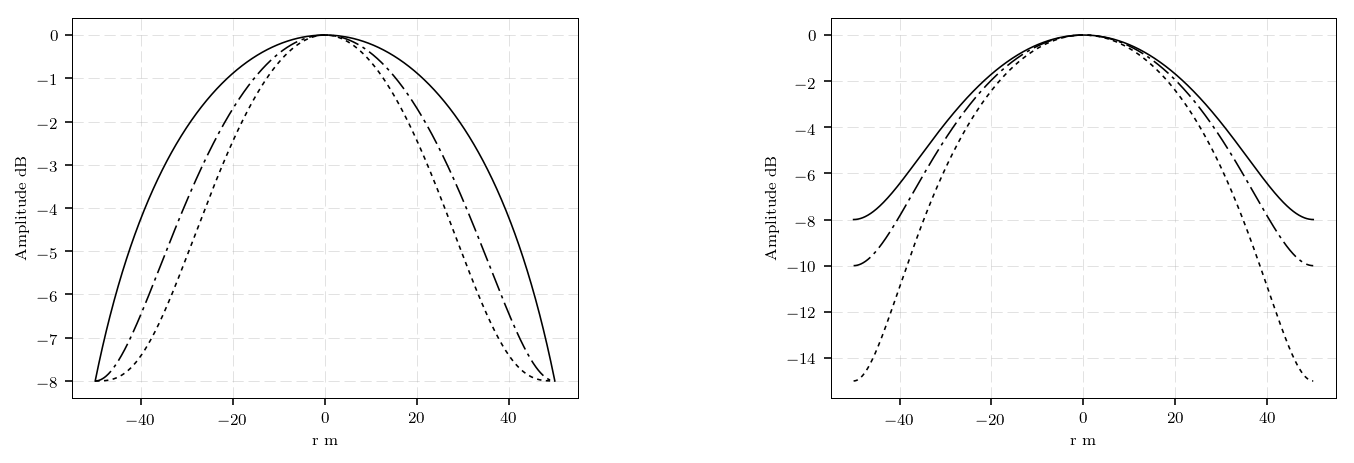

In [47]:
# importing the illumination functions
fig, ax = plt.subplots(ncols=2, figsize=(phi, factor/2))

for order, taper, linestyle in zip([1, 2, 3], [-8, -10, -15], ['-', '-.', ':']):
    _illum_order = aperture.illumination_pedestal(
        x=x, 
        y=0, 
        I_coeff=[1, -8, 0, 0],
        pr=pr,
        order=order
        )
    
    __illum_taper = aperture.illumination_pedestal(
        x=x,
        y=0,
        I_coeff=[1, taper, 0, 0],
        pr=pr,
        order=2
        )
    ax[0].plot(x, 20 * np.log10(_illum_order), linestyle=linestyle, c='k')
    ax[1].plot(x, 20 * np.log10(__illum_taper), linestyle=linestyle, c='k')

for _ax in ax:
    _ax.set_xlabel('r m')
    _ax.set_ylabel('Amplitude dB')


The application of the illumination to the blockage structure is straight forward, just a simple multiplication.

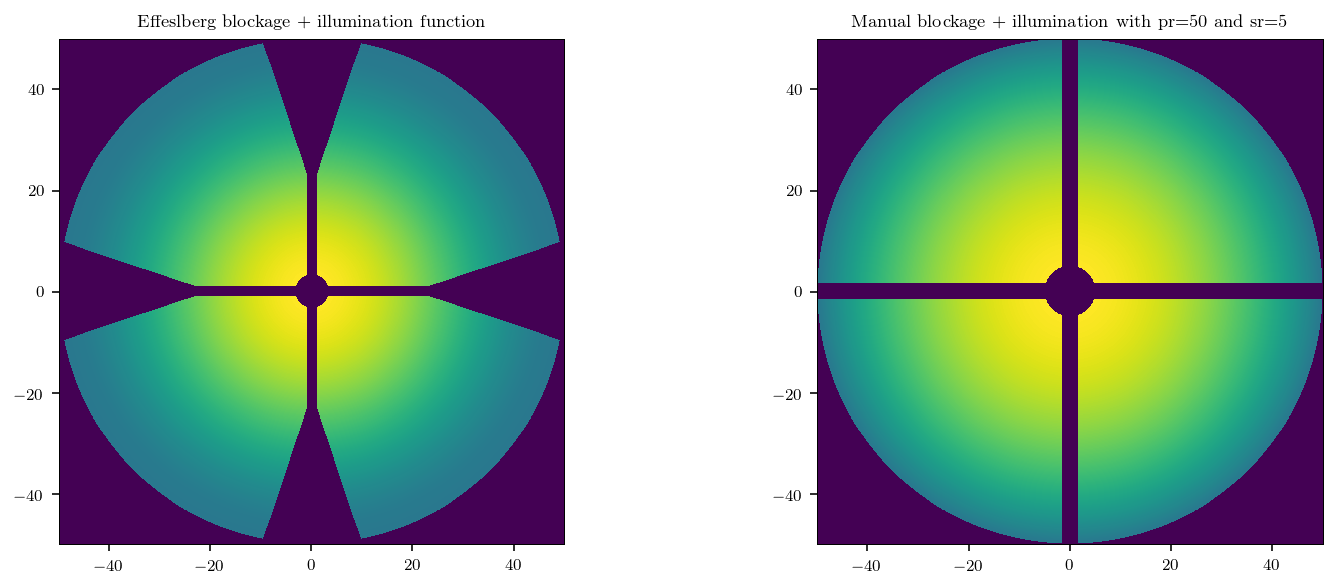

In [48]:
# Defining the illumination function for the Effelsberg telecope
_illum_effeslberg = aperture.illumination_pedestal(x=x_grid, y=y_grid, I_coeff=[1, -8, 0, 0], pr=pr, order=2)
_illum_manual = aperture.illumination_pedestal(x=x_grid, y=y_grid, I_coeff=[1, -8, 0, 0], pr=pr, order=1)

_aperture_nophase_effelsber = _blockage_effelsberg * _illum_effeslberg
_aperture_nophase_manual = _blockage_manual * _illum_manual

fig, ax = plt.subplots(ncols=2)

ax[0].set_title('Effeslberg blockage + illumination function')
ax[0].imshow(_aperture_nophase_effelsber, extent=extent)

ax[1].set_title('Manual blockage + illumination with pr=' + str(pr) + ' and sr=' + str(sr))
ax[1].imshow(_aperture_nophase_manual, extent=extent)

for _ax in ax:
    _ax.grid('off')

plt.show()

### Phase
For the final function, the phase, please look first at the zernike notebook first, which explains the formulation of the Zernike cirlce polynomials and their coefficients. The `phi` function is called, then

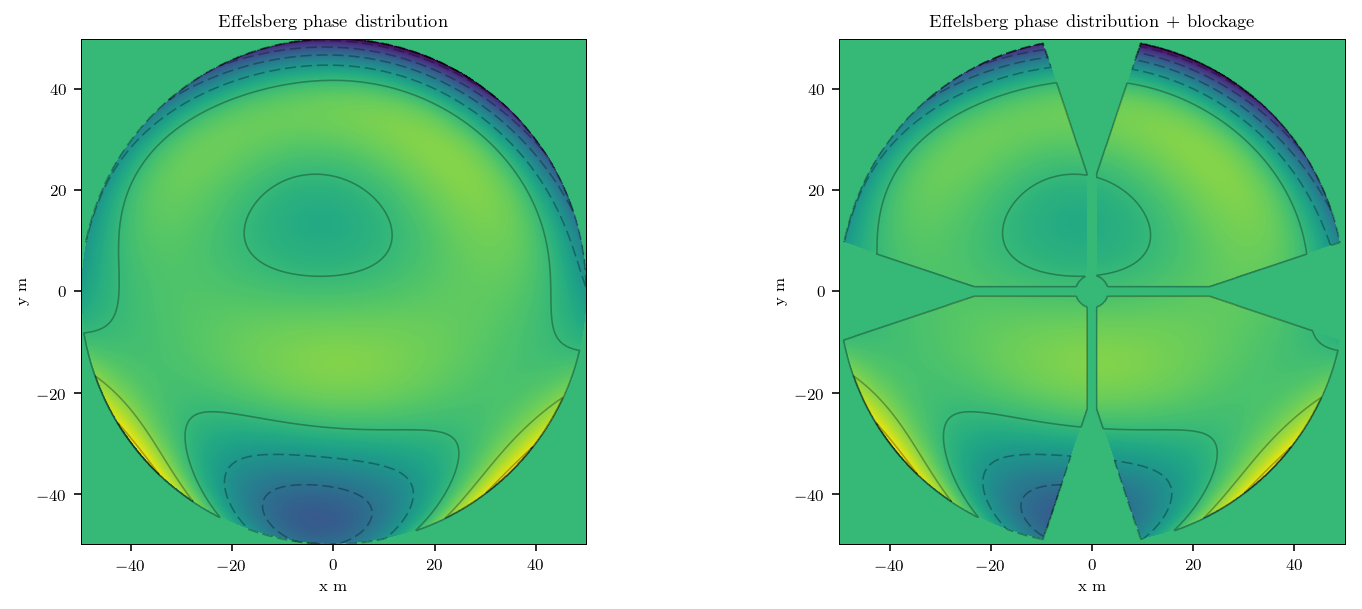

In [99]:
# Coefficients from example
K_coeff = ascii.read('fitpar_n5.dat')['parfit'][4:]

# no Tilt
K_coeff[1] = 0
K_coeff[2] = 0

r, t = cart2pol(x_grid, y_grid)
# Zernike circle polynomials exit in unitary circle
r_norm = r / pr

# The output is in radians
phase = aperture.phi(rho=r_norm, theta=t, K_coeff=K_coeff)
phase[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0


fig, ax = plt.subplots(ncols=2)

ax[0].imshow(phase, extent=extent)
ax[0].contour(x_grid, y_grid, phase, level=5, colors='k', alpha=0.3)
ax[0].set_title('Effelsberg phase distribution')

ax[1].imshow(phase * _blockage_effelsberg, extent=extent)
ax[1].contour(x_grid, y_grid, phase * _blockage_effelsberg, level=5, colors='k', alpha=0.3)
ax[1].set_title('Effelsberg phase distribution + blockage')

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('x m')
    _ax.set_ylabel('y m')

plt.show()

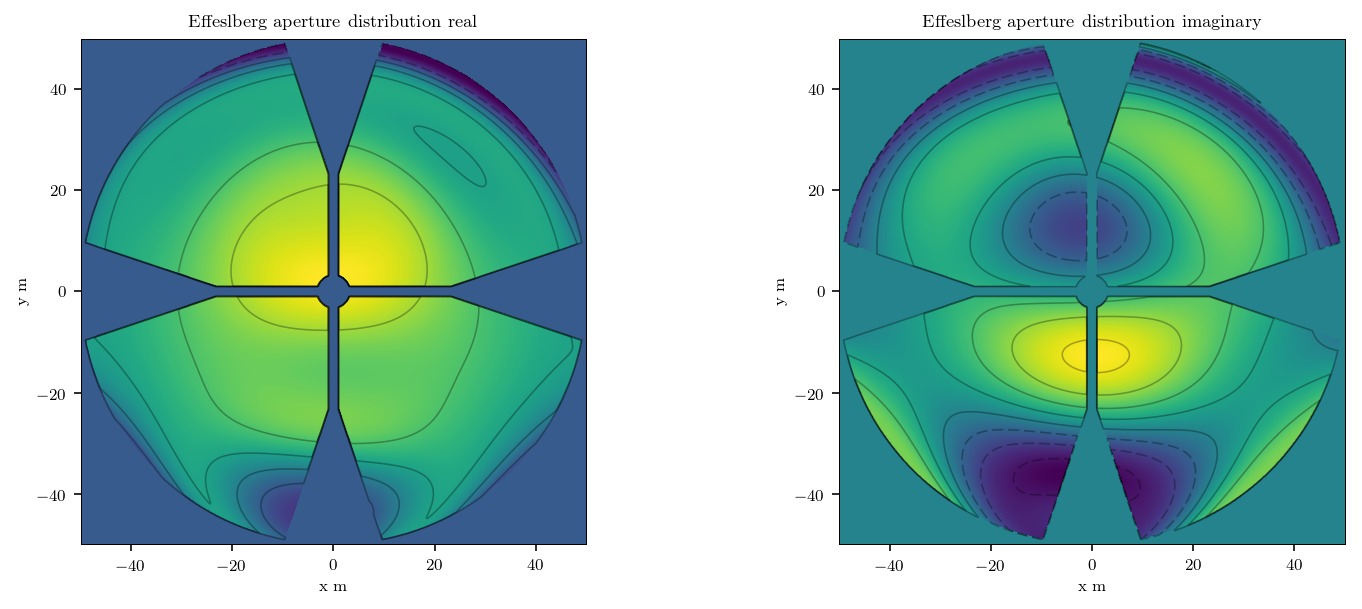

In [97]:
fig, ax = plt.subplots(ncols=2)

# then the final aperture
aperture_effelsberg = (np.exp(1j * phase) * _aperture_nophase_effelsber)

ax[0].imshow(aperture_effelsberg.real, extent=extent)
ax[0].contour(x_grid, y_grid, aperture_effelsberg.real, level=5, colors='k', alpha=0.3)
ax[0].set_title('Effeslberg aperture distribution real')

ax[1].imshow(aperture_effelsberg.imag, extent=extent)
ax[1].contour(x_grid, y_grid, aperture_effelsberg.imag, level=5, colors='k', alpha=0.3)
ax[1].set_title('Effeslberg aperture distribution imaginary')

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('x m')
    _ax.set_ylabel('y m')

The above result is the phase and aperture distributions in the telescope's primary dish. The effects of the phase might. It is whileworth to mention that the phi function comes from the aberration or wavefront distribution, $\phi = \frac{2\pi}{\lambda} W(x, y)$, where $\lambda$ comes from the observed frequency and it is already included in the Zernike coefficients for the Zernike circle polynomials.